# https://tinyurl.com/uwf-fast-ai

# Week 4, Regression, Custom Datasets

<h2> Regression with BIWI head pose dataset </h2>

Task: Find the center of a head in a given image




<h2> Get our libraries </h2>

In [0]:
!git clone https://github.com/muellerzr/ML_Useful_Functions.git
from ML_Useful_Functions.Functions import *
plotFunctions()

Cloning into 'ML_Useful_Functions'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 165 (delta 18), reused 11 (delta 6), pack-reused 133
Receiving objects: 100% (165/165), 53.57 KiB | 4.87 MiB/s, done.
Resolving deltas: 100% (94/94), done.


FileNotFoundError: ignored

In [0]:
from fastai import *
from fastai.vision import *

<h2> Getting and prepping the data </h2>

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

The depth data was taken from an Xbox Kinect so we have to do some calibration numbers we have to generate to make this dataset useful to us

In [0]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

Now let's analyze one photo to ensure we have calibrated for it correctly

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f):
  # We take in a filename, and return the label associated with it
  return path/f'{str(f)[:-7]}pose.txt'

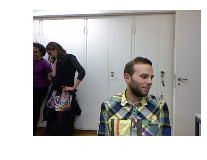

In [0]:
img = open_image(path/fname)
img.show()

In [0]:
cen = np.genfromtxt(img2txt_name(fname), skip_header=3); cen

array([187.332 ,  40.3892, 893.135 ])

Provided functions for taking coordinates from Kinect to actual pixel coordinates

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

All of the mess above is basically what they told you had to happen to generate their dataset

In [0]:
get_ctr(fname)

tensor([263.9104, 428.5814])

In [0]:
ctr = get_ctr(fname)

Now let's overlay this onto our image

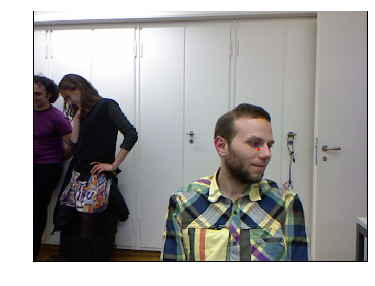

In [0]:
img.show(y = get_ip(img, ctr), figsize=(6,6))

Image points are not pixel values, they are XY coordinates, that is it. This is not classification anymore, this is regression. Regression is any kind of model where the output is a continous or set of numbers.

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch()
        .normalize(imagenet_stats)
       )

Lambda can take any number of arguments, but is one expression. 

In [0]:
lambda o: o.parent.name == '13'

<function __main__.<lambda>>

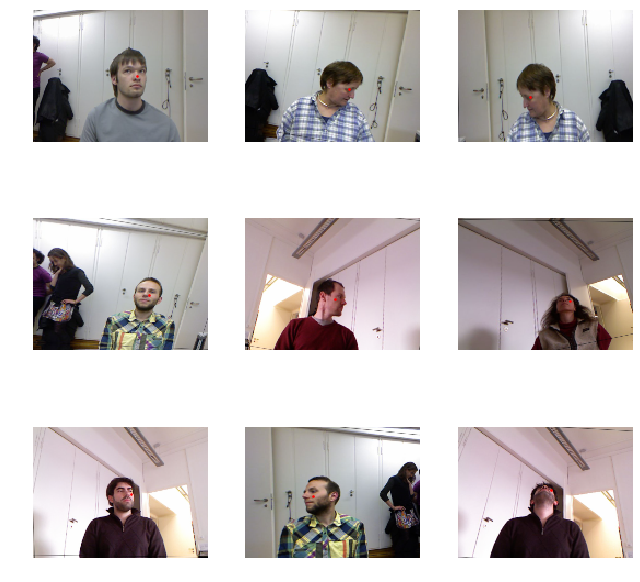

In [0]:
data.show_batch(3, figsize=(9,9))

Not always quite in the middle, not an issue on our end

<h2> Make the model! </h2>

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=MSELossFlat())

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 139443273.07it/s]


Notice we didn't display metrics. We have no metrics needed here really. Instead we want a different loss function. Remember, metrics are YOUR way of seeing the overall accuracy, the loss function is the MODEL's way of knowing how it's doing. 

For classification, this was called cross-entropy loss, did we predict correctly and were we confident in our prediction
For regression, we use mean squared error. 

In [0]:
learn.loss_func = MSELossFlat()

First freeze to the top section of layers

In [0]:
learn.freeze()

In [0]:
learn.lr_find()
lr = learn.recorder.plot(suggestion = True, return_lr=True, slc=True)

epoch,train_loss,valid_loss,time


In [0]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.068068,0.001857,02:46
1,0.017574,0.002882,02:50
2,0.006031,0.001228,02:46
3,0.002559,0.000535,02:56
4,0.001605,0.000332,02:48


Then do the rest of the model

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


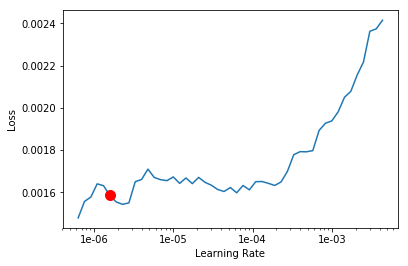

In [0]:
learn.lr_find()
lr = learn.recorder.plot(suggestion = True, return_lr=True, slc=True)

In [0]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,time
0,0.001614,0.000308,02:47


In [0]:
learn.validate()

[0.00030816311]

# Rossman and Time Series